# Trajectories analysis 1 (distributions and some statistsics)
This notebook shows different analysis routines for trajectories of groups extracted with [idtracker.ai](idtracker.ai). If you use this code and/or data generated from [idtracker.ai](idtracker.ai), please cite:

**Romero-Ferrero, F., Bergomi, M.G., Hinz, R.C., Heras, F.J.H., de Polavieja, G.G., Nature Methods, 2019. idtracker.ai: tracking all individuals in small or large collectives of unmarked animals (F.R.-F. and M.G.B. contributed equally to this work. Correspondence should be addressed to G.G.d.P: gonzalo.polavieja@neuro.fchampalimaud.org)**


To load and analyse the trajectories we will be using the python library *trajectorytools*, you can install with `pip install trajectorytools`. If you use it, please cite:

**Heras, F. J. H., Romero-Ferrero, F., Hinz, R. C., & de Polavieja, G. G. (2019). Deep attention networks reveal the rules of collective motion in zebrafish. PLoS computational biology, 15(9), e1007354.**

## Importing necessary python modules

In [1]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# trajectorytools needs to be installed. To install,
# pip install trajectorytools or follow the instructions at
# https://gitlab.com/polavieja_lab/trajectorytools
import trajectorytools as tt

## Load trajectories and setting parameters

Check the notebook T0_loading_idtrackerai_trajectories for more detailed instructions about loading idtracker.ai trajectories.

In [2]:
# Set path where to load trajectories from
trajectories_path = "../data/test_trajectories.npy"
tr = tt.Trajectories.from_idtrackerai(
    trajectories_path, interpolate_nans=True, smooth_params={"sigma": 1}
)
# Since the arena of the setup was circular and the fish visited the borders of the arena
# we use the estimate_center_and_radius_from_locations to center the trajectories
# in the arena
center, radius = tr.estimate_center_and_radius_from_locations(in_px=True)
tr.origin_to(center)
# In our case we know that the body_length_px is a good estimate for the body length
# since we loaded the trajectories with the method from_idtrackerai this value is
# stored in the tr.params disctionary
tr.new_length_unit(tr.params["body_length_px"], "BL")
# Since we loaded the trajectories with the method from_idtrackerai we can
# use the frame_rate variable stored in the tr.params disctioanry to
# to set the time units to seconds
tr.new_time_unit(tr.params["frame_rate"], "s")
print("Positions:")
print("X range:", np.nanmin(tr.s[..., 0]), np.nanmax(tr.s[..., 0]), "BL")
print("Y range:", np.nanmin(tr.s[..., 1]), np.nanmax(tr.s[..., 1]), "BL")
print("Velcities:")
print("X range:", np.nanmin(tr.v[..., 0]), np.nanmax(tr.v[..., 0]), "BL/s")
print("Y range:", np.nanmin(tr.v[..., 1]), np.nanmax(tr.v[..., 1]), "BL/s")
print("Accelerations:")
print("X range:", np.nanmin(tr.a[..., 0]), np.nanmax(tr.a[..., 0]), "BL/s^2")
print("Y range:", np.nanmin(tr.a[..., 1]), np.nanmax(tr.a[..., 1]), "BL/s^2")
pprint(tr.params)

Positions:
X range: -22.857960805634484 23.004886491518306 BL
Y range: -23.15551579252565 23.09623793320273 BL
Velcities:
X range: -24.308591158867152 25.440020858505456 BL/s
Y range: -27.244428384301894 21.108243189033033 BL/s
Accelerations:
X range: -580.2747863777576 1202.8359590531866 BL/s^2
Y range: -375.60146057076224 346.45476781825226 BL/s^2
{'_center': array([1782.57651696, 1761.71033149]),
 'body_length_px': 69.0,
 'construct_method': 'from_idtrackerai',
 'displacement': array([-1782.57651696, -1761.71033149]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': 69.0,
 'length_unit_name': 'BL',
 'path': '../data/test_trajectories.npy',
 'radius': 23.18884521417357,
 'radius_px': 1600.0303197779763,
 'smooth_params': {'sigma': 1},
 'time_unit': 32,
 'time_unit_name': 's'}


## Histogram of positions, speed and acceleration

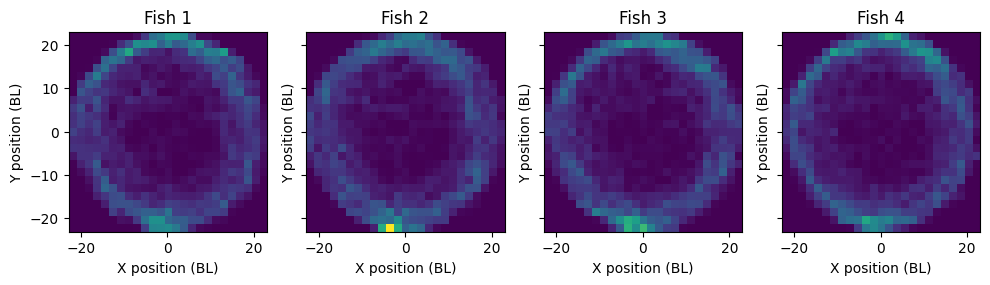

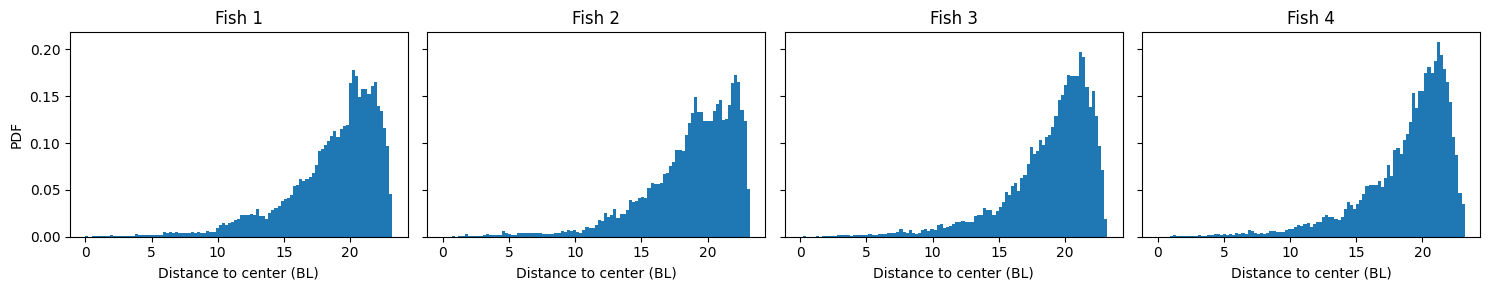

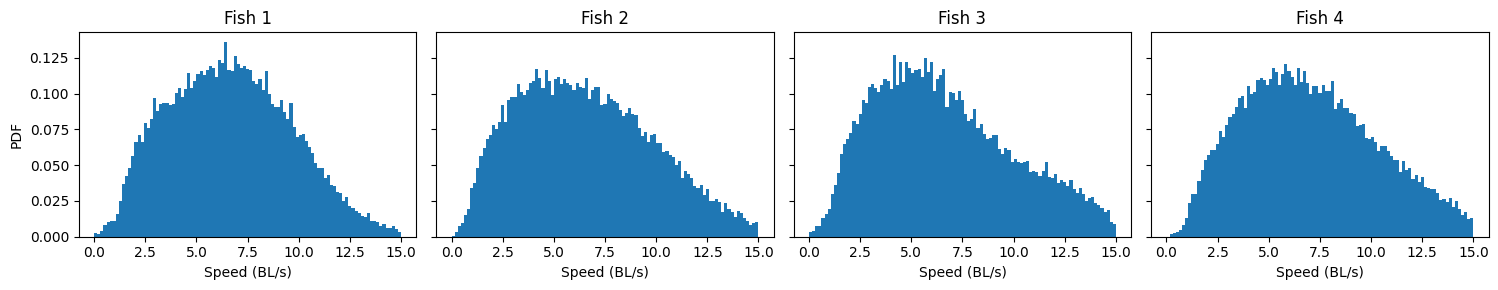

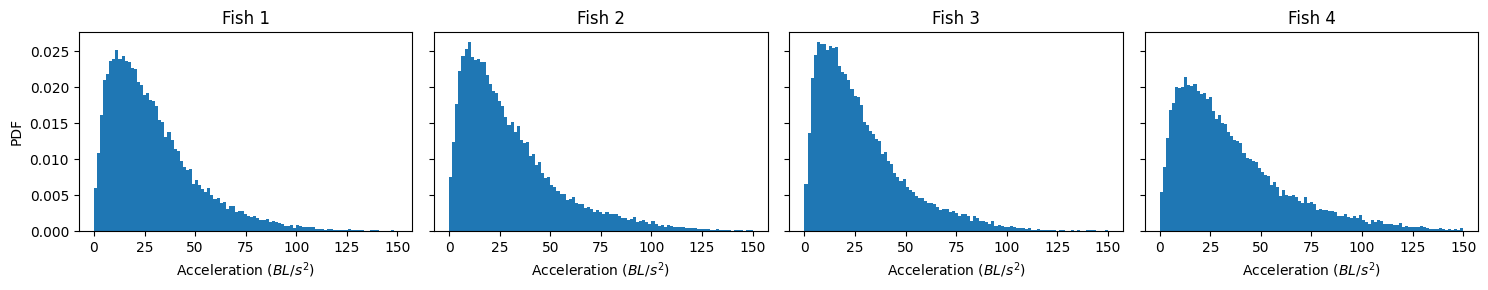

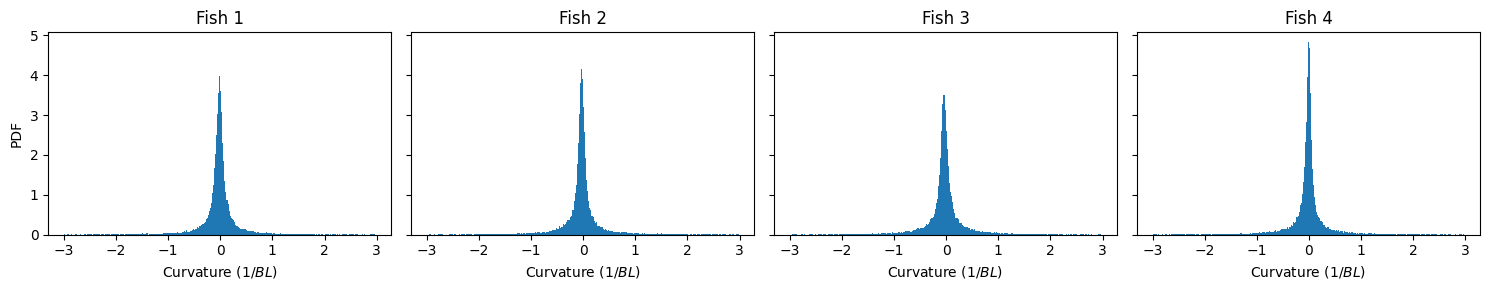

In [3]:
def histogram(data: np.ndarray, nbins: int | np.ndarray, label: str):
    figv, ax_hist = plt.subplots(
        1, tr.number_of_individuals, figsize=(15, 3), sharey=True
    )
    for focal, ax in enumerate(ax_hist):
        ax.hist(data[:, focal][~np.isnan(data[:, focal])], nbins, density=True)
        ax.set(title=f"Fish {focal + 1}", xlabel=label)
    ax_hist[0].set(ylabel="PDF")
    figv.tight_layout()
    return figv, ax_hist


hist2d: list[np.ndarray] = []

for focal in range(tr.number_of_individuals):
    hist2d.append(
        np.histogram2d(
            tr.s[:, focal, 0][~np.isnan(tr.s[:, focal, 0])],
            tr.s[:, focal, 1][~np.isnan(tr.s[:, focal, 1])],
            25,
        )[0]
    )
vmax = np.asarray(hist2d).max()

# Plot distributions of positions in the arena
figv, ax_hist = plt.subplots(
    1, tr.number_of_individuals, figsize=(10, 3), sharey=True, sharex=True
)
min_x, max_x = np.nanmin(tr.s[..., 0]), np.nanmax(tr.s[..., 0])
min_y, max_y = np.nanmin(tr.s[..., 1]), np.nanmax(tr.s[..., 1])
for focal, ax in enumerate(ax_hist):
    ax.imshow(
        np.rot90(hist2d[focal]),
        interpolation="none",
        extent=[min_x, max_x, min_y, max_y],
        vmin=0,
        vmax=vmax,
    )
    ax.set(
        xlabel="X position (BL)",
        ylabel="Y position (BL)",
        title=f"Fish {focal + 1}",
        aspect="equal",
    )
figv.tight_layout()

# Plot distance to center of the arena histograms for each fish
nbins = np.linspace(0, np.nanmax(tr.distance_to_origin), 100)
figv, ax_flat = histogram(tr.distance_to_origin, nbins, "Distance to center (BL)")


# Plot speed histograms for each fish
nbins = np.linspace(0, 15, 100)  # ADJUST THE RANGE BINS TO YOUR DATA
figv, ax_flat = histogram(tr.speed, nbins, "Speed (BL/s)")


# Plot acceleration histograms for each fish
nbins = np.linspace(0, 150, 100)  # ADJUST THE RANGE BINS TO YOUR DATA
figva, ax_flata = histogram(tr.acceleration, nbins, "Acceleration ($BL/s^2$)")


# Plot curvature histograms for each fish
nbins = np.arange(-3, 3, 0.02)
figvc, ax_flatc = histogram(tr.curvature, nbins, "Curvature ($1/BL$)")

## A smoother version of the positions heatmap with Gaussian KDE

In [4]:
v_max = 0
min_x, max_x = np.nanmin(tr.s[..., 0]), np.nanmax(tr.s[..., 0])
min_y, max_y = np.nanmin(tr.s[..., 1]), np.nanmax(tr.s[..., 1])
X, Y = np.mgrid[min_x:max_x:50j, min_y:max_y:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
G_kernels = []
for i in range(tr.number_of_individuals):
    print("computing Gaussian kernel for fish ", i)
    values = tr.s[~np.isnan(tr.s[:, i, 0]), i, :].T
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    G_kernels.append(Z)
    v_max = max(v_max, G_kernels[i].max())

computing Gaussian kernel for fish  0
computing Gaussian kernel for fish  1
computing Gaussian kernel for fish  2
computing Gaussian kernel for fish  3


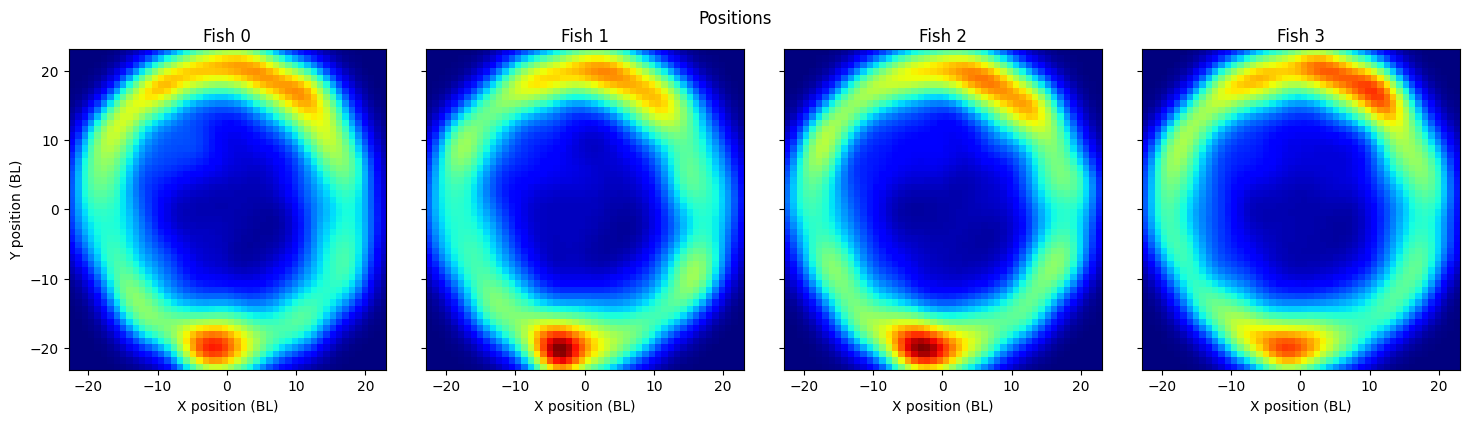

In [7]:
fig, ax_arr = plt.subplots(
    1, tr.number_of_individuals, sharex=True, sharey=True, figsize=(15, 4)
)
fig.suptitle("Positions")

for i, ax in enumerate(ax_arr):
    ax.imshow(
        np.rot90(G_kernels[i]),
        cmap="jet",
        extent=[min_x, max_x, min_y, max_y],
        vmin=0,
        vmax=v_max,
    )
    ax.set(
        title=f"Fish {i}",
        xlabel="X position (BL)",
        aspect="equal",
    )
ax_arr[0].set(ylabel="Y position (BL)")
fig.tight_layout()